<a href="https://colab.research.google.com/github/zjzsu2000/RL/blob/main/Copy_of_RL_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random


from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
stock_data1 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/VCYT.csv'))
stock_data2 =  pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/AMD.csv'))
stock_data3 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/AAPL.csv'))
stock_data4 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/NSTG.csv'))
stock_data5 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/NIO.csv'))
stock_data6 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/JYNT.csv'))
stock_data7 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/NQSDA.csv'))
stock_data8 = pd.read_csv(('/gdrive/My Drive/Data set/Stock/three_years/KODK.csv'))

In [ ]:
NQSDA_Index =  [] 
stock_data7 = stock_data7[stock_data7.Date.isin(stock_data8.Date.values)]
amount_stock_NQSDA = 100000/stock_data7.Close[0]
for price in stock_data7['Close'].tolist() : 
  NQSDA_Index.append(amount_stock_NQSDA *price)

In [ ]:
len(NQSDA_Index)

731

In [ ]:
df = stock_data2
print(df.head())

         Date   Open   High    Low  Close  Adj Close     Volume
0  2018-01-02  10.42  11.02  10.34  10.98      10.98   44146300
1  2018-01-03  11.61  12.14  11.36  11.55      11.55  154066700
2  2018-01-04  12.10  12.43  11.97  12.12      12.12  109503000
3  2018-01-05  12.19  12.22  11.66  11.88      11.88   63808900
4  2018-01-08  12.01  12.30  11.85  12.28      12.28   63346000


No handles with labels found to put in legend.


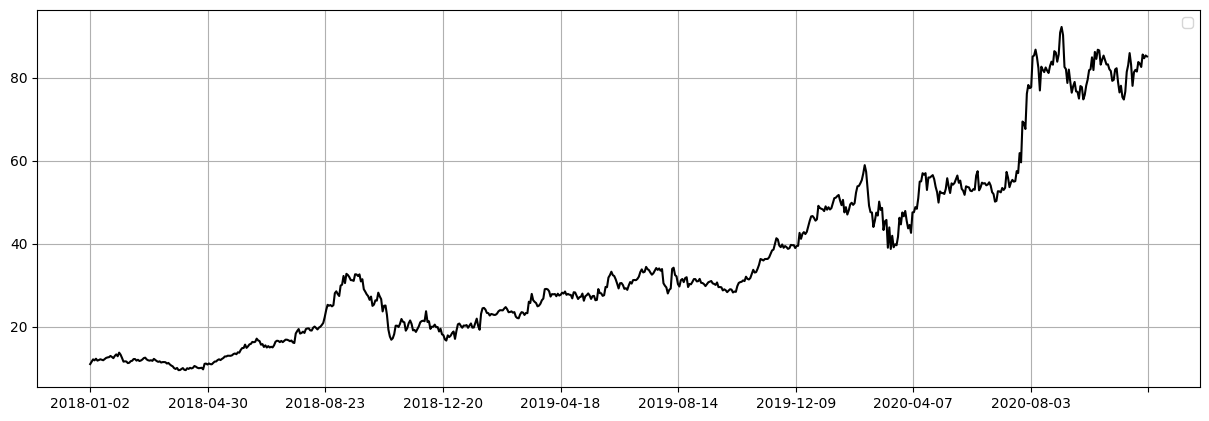

In [ ]:
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(df['Date'], df['Close'], color='black')
plt.xticks(np.linspace(0, len(df), 10))
plt.legend()
plt.grid()

In [ ]:
df=df.sort_values('Date', ascending=True).reset_index(drop=True)

# caculate MA（moving avarage price）
for day in [5, 10, 21, 30]:
    df['ma'+str(day)] = df.Close.rolling(day).mean()

col = ['ma5', 'ma10', 'ma21', 'ma30']
tmp_df2 = df[col].shift(1)
tmp_df3 = df[col].shift(2)
for tmp_col in col:
    df[tmp_col + '_trend'] = 0
    # tmp_df[tmp_col + '_shift_1'] = tmp_df2[tmp_col]
    # tmp_df[tmp_col _ 'shift_2'] = tmp_df3[tmp_col]
    df['rate1'] = (tmp_df2[tmp_col] - tmp_df3[tmp_col]) / (tmp_df3[tmp_col] + 0.00001)
    df['rate2'] = (df[tmp_col] - tmp_df2[tmp_col]) / (tmp_df2[tmp_col] + 0.00001)
    idx = (df['rate1'] > 0.005) & (df['rate2'] > 0.005)
    df.loc[idx, tmp_col + '_trend'] = 1 # trend going up

    idx = (df['rate1'] < -0.005) & (df['rate2'] < -0.005)
    df.loc[idx, tmp_col + '_trend'] = 2 # # trend going down



df = df.loc[31:].reset_index(drop=True)
df_copy = df.copy()

In [ ]:
df_copy

,Date,Open,High,Low,Close,Adj Close,Volume,ma5,ma10,ma21,ma30,ma5_trend,rate1,rate2,ma10_trend,ma21_trend,ma30_trend
0,2018-02-15,12.400000,12.630000,12.070000,12.190000,12.190000,59593800,11.832000,11.765,12.359524,12.262000,1,0.003333,0.001743,2,0,0
1,2018-02-16,12.110000,12.230000,11.820000,11.820000,11.820000,47332300,11.934000,11.702,12.328571,12.252000,1,0.001743,-0.000816,2,0,0
2,2018-02-20,11.720000,12.190000,11.710000,12.020000,12.020000,47096500,12.002000,11.747,12.301429,12.256667,1,-0.000816,0.000381,0,0,0
3,2018-02-21,12.120000,12.120000,11.720000,11.720000,11.720000,40195800,11.990000,11.754,12.257143,12.238000,0,0.000381,-0.001523,0,0,0
4,2018-02-22,11.820000,12.000000,11.630000,11.840000,11.840000,37886300,11.918000,11.778,12.204762,12.238667,0,-0.001523,0.000054,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2020-11-18,83.010002,83.959999,82.220001,82.540001,82.540001,29968000,82.580000,82.417,80.390476,81.381666,0,-0.000458,-0.001697,0,0,0
696,2020-11-19,82.389999,85.639999,81.720001,85.540001,85.540001,50116800,83.320001,82.671,80.692381,81.349333,0,-0.001697,-0.000397,0,0,0
697,2020-11-20,85.279999,86.099998,84.470001,84.639999,84.639999,34974800,83.962001,82.547,80.940952,81.400666,1,-0.000397,0.000631,0,0,0
698,2020-11-23,85.519997,87.540001,84.620003,85.309998,85.309998,46505000,84.278000,82.766,81.100476,81.434666,0,0.000631,0.000418,0,0,0


In [ ]:
#todo: Position control strategy
# https://www.investopedia.com/articles/trading/10/create-trading-strategies.asp

def compute_score(index_df, i):
    score = 0
    tmp_rate = (index_df['Close'][i]-index_df['ma5'][i])
    if tmp_rate>=0:
        score += 1
        
    tmp_rate = (index_df['Close'][i]-index_df['ma10'][i])
    if tmp_rate>=0:
        score += 1.5
    elif tmp_rate>-0.03:
        score += 1
    elif tmp_rate>-0.06:
        score += 0.5
    
    tmp_rate = (index_df['Close'][i]-index_df['ma21'][i])
    if tmp_rate>=0:
        score += 1.5
    elif tmp_rate>-0.03:
        score += 1
    elif tmp_rate>-0.06:
        score += 0.5

    tmp_rate = (index_df['Close'][i]-index_df['ma30'][i])
    if tmp_rate>=0:
        score += 1
    elif tmp_rate>-0.5:
        score += 0.5
    
    if index_df['ma5_trend'][i] == 1:
        score += 1
    
    if index_df['ma10_trend'][i] == 1:
        score += 1.5
    elif index_df['ma10_trend'][i] == 0:
        score += 0.5

    if index_df['ma21_trend'][i] == 1:
        score += 1.5
    elif index_df['ma21_trend'][i] == 0:
        score += 0.5
        
    if index_df['ma21_trend'][i] == 1:
        score += 1
    elif index_df['ma21_trend'][i] == 0:
        score += 0.5
        
    return score

# Manual strategy

def print_info(hold_money, hold_market_value, index_df, i, kind, change_amount):
    trade_date = index_df['Date'][i]
    change_amount = round(change_amount,2)
    rate = (index_df['Close'][i] - index_df['Close'][i-1]) / index_df['Close'][i-1]
    rate = round(rate, 2)
    info = str(trade_date)
    if rate > 0:
        info += ', going up ' + str(rate)
    else:
        info += ', going down ' + str(rate)
        
    if kind == 1:
        info += ', buy ' + str(change_amount) 
    
    elif kind == 2:
        info += ', sell ' + str(change_amount) 
    
    info += ',hold money：'+str(round(hold_money,2))+',stocks_value：'+\
    str(round(hold_market_value,2))+',total_market_value：'+str(round(hold_money+hold_market_value,2))
    print(info)


score_list = []
hold_mount = 0
money_init = 100000
hold_money = money_init
hold_market_value = 0
hold_market_value_list = []
hold_money_list = []
all_value_list_manual = []
change_amount = 0
for i in range(len(df)):
    score = compute_score(df, i) / 10    
    #print(str(score))
    if i == 0:
        buy_money = int(money_init * score)
        hold_market_value = buy_money
        hold_money = hold_money - buy_money
        print(str(df['Date'][i])+'buy：'+str(str(buy_money)))
        print(hold_market_value)
    else:
        hold_market_value = hold_market_value * df['Close'][i]/df['Close'][i-1]
        print(hold_market_value)
        if score_list[-1] == score:
            kind = 0
            
        elif score_list[-1] < score: #buy
            if score_list[-1] == 0:
                add_mount = score
            else:
                add_mount = score - score_list[-1]
            
            buy_money = int(hold_money/(1-score_list[-1])* (add_mount))
            hold_market_value += buy_money
            hold_money -= buy_money
            kind = 1
            change_amount = add_mount
            
        else: #sell
            reduce_mount =  score_list[-1] - score
            sell_money = int(hold_market_value/score_list[-1] * (reduce_mount))
            hold_market_value -= sell_money
            hold_money += sell_money
            change_amount = sell_money
            kind = 2
            
        print_info(hold_money, hold_market_value, df, i, kind, change_amount) 
        
    score_list.append(score)
    hold_market_value_list.append(hold_market_value)
    hold_money_list.append(hold_money)
    all_value_list_manual.append(hold_money+hold_market_value)

2018-02-15buy：50000
50000
48482.362592288766
2018-02-16, going down -0.03, sell 9696,hold money：59696,stocks_value：38786.36,total_market_value：98482.36
39442.64622329196
2018-02-20, going up 0.02, buy 0.15,hold money：44772,stocks_value：54366.65,total_market_value：99138.65
53009.74157545606
2018-02-21, going down -0.02, sell 33733,hold money：78505,stocks_value：19276.74,total_market_value：97781.74
19474.114356092126
2018-02-22, going up 0.01, buy 0.15,hold money：63786,stocks_value：34193.11,total_market_value：97979.11
34857.338705914866
2018-02-23, going up 0.02, buy 0.1,hold money：53973,stocks_value：44670.34,total_market_value：98643.34
45965.66750020403
2018-02-26, going up 0.03, buy 0.3,hold money：24534,stocks_value：75404.67,total_market_value：99938.67
76072.50271961003
2018-02-27, going up 0.01, buy 0.1,hold money：14721,stocks_value：85885.5,total_market_value：100606.5
83006.65905303092
2018-02-28, going down -0.03, sell 24413,hold money：39134,stocks_value：58593.66,total_market_value：97

# DQN with pytorch

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(1)
torch.manual_seed(41)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        units = 32
        self.fc1 = nn.Linear(input_shape, units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(units, n_actions)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = torch.tensor(reward_decay, dtype=torch.float)
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))
        
        self.net = DQN(n_features, n_actions).to(device)
        self.tgt_net = DQN(n_features, n_actions).to(device)
        
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)


    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        transition = np.hstack((s, [a, r], s_))

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition

        self.memory_counter += 1

    def choose_action(self, observation, train=True):
        # to have batch dimension when feed into tf placeholder
        observation = [observation[np.newaxis, :]]
        observation = torch.tensor(observation, dtype=torch.float32).to(device)
        
        if np.random.uniform() < self.epsilon or (train == False):
            # forward feed the observation and get q value for every actions
            actions_value = self.net(observation).detach().cpu().squeeze(0)
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        self.net.train()
        self.tgt_net.train()
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.tgt_net.load_state_dict(self.net.state_dict())
            # print('\ntarget_params_replaced\n')
            
        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        
        batch_memory = self.memory[sample_index, :]
        s_ = torch.tensor(batch_memory[:, -self.n_features:], dtype=torch.float32).to(device)
        s = torch.tensor(batch_memory[:, :self.n_features], dtype=torch.float32).to(device)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = torch.tensor(batch_memory[:, self.n_features + 1], dtype=torch.float32)
        
        q_next = self.tgt_net(s_)
        q_eval = self.net(s)

        # # change q_target w.r.t q_eval's action
        q_target = q_eval.clone()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        max_, _ = torch.max(q_next, dim=1)
        q_target[batch_index, eval_act_index] = reward + self.gamma * max_
        
        # loss backpropogation
        self.optimizer.zero_grad()
        loss = nn.MSELoss()(q_eval, q_target)
#        print(loss)
        loss.backward()
        self.optimizer.step()
        
        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

In [ ]:
#Env

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class stock:
    
    def __init__(self, df, init_money=100000, window_size=6):
        
        self.n_actions = 3 # 动作数量
        self.n_features = window_size # 特征数量   
        self.trend = df['Close'].values # 收盘数据
        self.df = df #数据的DataFrame
        self.init_money = init_money # 初始化资金
        
        self.window_size = window_size #滑动窗口大小
        self.half_window = window_size // 2
        
        self.buy_rate = 0.0003  # 买入费率
        self.buy_min = 5  # 最小买入费率
        self.sell_rate = 0.0003  # 卖出费率
        self.sell_min = 5  # 最大买入费率
        self.stamp_duty = 0.001  # 印花税
        
    def reset(self):
        self.hold_money = self.init_money # 持有资金
        self.buy_num = 0 # 买入数量
        self.hold_num = 0 # 持有股票数量
        self.stock_value = 0 # 持有股票总市值
        self.market_value = 0 # 总市值（加上现金）
        self.last_value = self.init_money # 上一天市值
        self.total_profit = 0 # 总盈利
        self.t = self.window_size // 2 # 时间
        self.reward = 0 # 收益
        # self.inventory = []
        
        self.states_sell = [] #卖股票时间
        self.states_buy = [] #买股票时间
        
        self.profit_rate_account = [] # 账号盈利
        self.market_value_list = [] # 账号盈利
        self.profit_rate_stock = [] # 股票波动情况
        return self.get_state(self.t)
    
    def get_state(self, t): #某t时刻的状态
        
        window_size = self.window_size + 1
        d = t - window_size + 1
		#早期天数不够窗口打小，用0时刻来凑，即填补相应个数
        # block = self.trend[d : t + 1] if d >= 0 else (-d * [self.trend[0]] + self.trend[0 : t + 1])
        block = []
        if d<0:
            for i in range(-d):
                block.append(self.trend[0])
            for i in range(t+1):
                block.append(self.trend[i])
        else:
            block = self.trend[d : t + 1]
                
            
        res = []
        for i in range(window_size - 1):
            res.append((block[i + 1] - block[i])/(block[i]+0.0001)) #每步收益
        # res = []
            
        # if self.hold_num > 0:
        #     res.append(1)
        # else:
        #     res.append(0)
            
        # res.append((self.df['close'][t] - self.df['ma21'][t]) / self.df['ma21'][t])
        # res.append((self.df['close'][t] - self.df['ma13'][t]) / self.df['ma13'][t])
        # res.append((self.df['close'][t] - self.df['ma5'][t]) / self.df['ma5'][t])
        # res.append((self.df['vol'][t] - self.df['ma_v_21'][t]) / self.df['ma_v_21'][t])
        return np.array(res) #作为状态编码
    
    def buy_stock(self):       
        # 买入股票
        self.buy_num = self.hold_money // self.trend[self.t] // 100 # 买入手数
        self.buy_num = self.buy_num * 100
        
        # 计算手续费等
        tmp_money = self.trend[self.t] * self.buy_num
        service_change = tmp_money * self.buy_rate
        if service_change < self.buy_min:
            service_change = self.buy_min
        # 如果手续费不够，就少买100股
        if service_change + tmp_money > self.hold_money:
            self.buy_num = self.buy_num - 100
        tmp_money = self.trend[self.t] * self.buy_num
        service_change = tmp_money * self.buy_rate
        if service_change < self.buy_min:
            service_change = self.buy_min
            
        self.hold_num += self.buy_num
        self.stock_value += self.trend[self.t] * self.buy_num
        self.hold_money = self.hold_money - self.trend[self.t] * \
            self.buy_num - service_change
        self.states_buy.append(self.t)
    
    def sell_stock(self, sell_num):
        tmp_money = sell_num * self.trend[self.t]
        service_change = tmp_money * self.sell_rate
        if service_change < self.sell_min:
            service_change = self.sell_min
        stamp_duty = self.stamp_duty * tmp_money
        self.hold_money = self.hold_money + tmp_money - service_change - stamp_duty
        self.hold_num = 0
        self.stock_value = 0
        self.states_sell.append(self.t)
        
    def trick(self):
        if self.df['Close'][self.t] >= self.df['ma21'][self.t]:
            return True
        else:
            return False
    
    def step(self, action, show_log=False, my_trick=False):
        
        if action == 1 and self.hold_money >= (self.trend[self.t]*100 + \
            max(self.buy_min, self.trend[self.t]*100*self.buy_rate)) and self.t < (len(self.trend) - self.half_window):
            buy_ = True
            if my_trick and not self.trick(): 
                # 如果使用自己的触发器并不能出发买入条件，就不买
                buy_ = False
            if buy_ : 
                self.buy_stock()
                if show_log:
                    print('day:%d, buy price:%f, buy num:%d, hold num:%d, hold money:%.3f'% \
                          (self.t, self.trend[self.t], self.buy_num, self.hold_num, self.hold_money))
        
        elif action == 2 and self.hold_num > 0:
            # 卖出股票         
            self.sell_stock(self.hold_num)
            if show_log:
                print(
                    'day:%d, sell price:%f, total balance %f,'
                    % (self.t, self.trend[self.t], self.hold_money)
                )
        else:
            if my_trick and self.hold_num>0 and not self.trick():
                self.sell_stock(self.hold_num)
                if show_log:
                    print(
                        'day:%d, sell price:%f, total balance %f,'
                        % (self.t, self.trend[self.t], self.hold_money)
                    )
                    
        self.stock_value = self.trend[self.t] * self.hold_num

        self.market_value = self.stock_value + self.hold_money 
        self.total_profit = self.market_value - self.init_money
        
        # self.reward = (self.market_value - self.last_value) / self.last_value
        reward = (self.trend[self.t + 1] - self.trend[self.t]) / self.trend[self.t]
        if np.abs(reward)<=0.015:
            self.reward = reward * 0.2
        elif np.abs(reward)<=0.03:
            self.reward = reward * 0.7
        elif np.abs(reward)>=0.05:
            if reward < 0 :
                self.reward = (reward+0.05) * 0.1 - 0.05
            else:
                self.reward = (reward-0.05) * 0.1 + 0.05
        
        # reward = (self.trend[self.t + 1] - self.trend[self.t]) / self.trend[self.t]
        if self.hold_num > 0 or action == 2:                                
            self.reward = reward    
            if action == 2:
                self.reward = -self.reward
        else:
            self.reward = -self.reward * 0.1
            # self.reward = 0
        
        self.last_value = self.market_value
        self.market_value_list.append(self.market_value)
        self.profit_rate_account.append((self.market_value - self.init_money) / self.init_money)
        self.profit_rate_stock.append((self.trend[self.t] - self.trend[0]) / self.trend[0])
        done = False
        self.t = self.t + 1
        if self.t == len(self.trend) - 2:
            done = True
        s_ = self.get_state(self.t)
        reward = self.reward
        
        return s_, reward, done
    
    def get_info(self):
        return self.states_sell, self.states_buy, self.profit_rate_account, self.profit_rate_stock  
    
    def draw(self, save_name1, save_name2):
        # 绘制结果
        states_sell, states_buy, profit_rate_account, profit_rate_stock = self.get_info()
        invest = profit_rate_account[-1]
        total_gains = self.total_profit
        close = self.trend
        fig = plt.figure(figsize = (15,5))
        plt.plot(close, color='r', lw=2.)
        plt.plot(close, 'v', markersize=8, color='k', label = 'selling signal', markevery = states_sell)
        plt.plot(close, '^', markersize=8, color='m', label = 'buying signal', markevery = states_buy)        
        plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
        plt.legend()
        #plt.savefig(save_name1)
        plt.show()
        
        fig = plt.figure(figsize = (15,5))
        plt.plot(self.market_value_list, label='DQN')
        plt.plot(profit_rate_stock, label='buy&hold')
       # plt.plot(NQSDA_Index[500:], label='NQSDA_Index')
        plt.legend()
        #plt.savefig(save_name2)
        plt.show()

epoch:0, total_profit:330423.077
epoch:1, total_profit:760468.068
epoch:2, total_profit:909812.439
epoch:3, total_profit:1375126.398
epoch:4, total_profit:1922500.789
epoch:5, total_profit:1927557.718
epoch:6, total_profit:2410387.058
epoch:7, total_profit:2609248.799
epoch:8, total_profit:2568125.610
epoch:9, total_profit:2659290.907
day:3, buy price:11.720000, buy num:8500, hold num:8500, hold money:350.114
day:41, sell price:10.520000, total balance 89653.868000,
day:42, buy price:10.360000, buy num:8600, hold num:8600, hold money:531.139
day:50, sell price:10.880000, total balance 93977.500800,
day:51, buy price:11.130000, buy num:8400, hold num:8400, hold money:457.453
day:60, sell price:12.230000, total balance 103055.901600,
day:61, buy price:12.450000, buy num:8200, hold num:8200, hold money:935.275
day:73, sell price:14.400000, total balance 118861.770600,
day:74, buy price:14.850000, buy num:8000, hold num:8000, hold money:26.131
day:76, sell price:15.670000, total balance 12

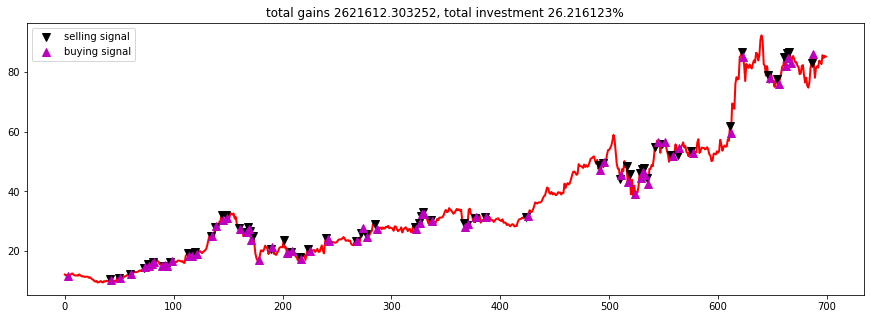

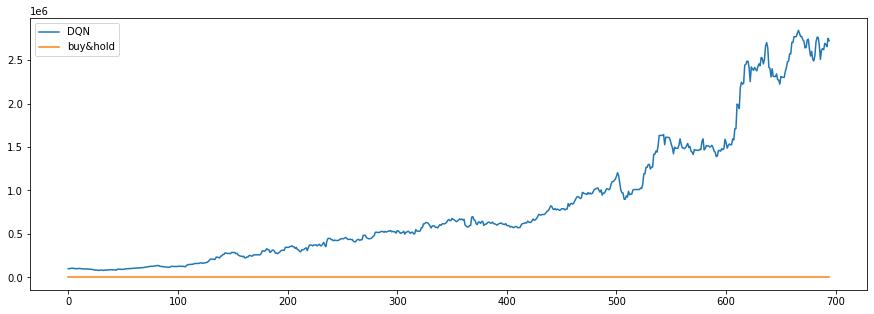

day:6, buy price:12.420000, buy num:8000, hold num:8000, hold money:610.192
day:9, sell price:11.900000, total balance 95686.432000,
day:11, buy price:11.910000, buy num:8000, hold num:8000, hold money:377.848
day:12, sell price:11.760000, total balance 94335.544000,
day:13, buy price:12.240000, buy num:7700, hold num:7700, hold money:59.270
day:15, sell price:11.700000, total balance 90032.152600,
day:42, buy price:10.360000, buy num:8600, hold num:8600, hold money:909.424
day:44, sell price:9.990000, total balance 86711.735600,
day:45, buy price:10.040000, buy num:8600, hold num:8600, hold money:341.832
day:47, sell price:9.710000, total balance 83739.274600,
day:48, buy price:11.040000, buy num:7500, hold num:7500, hold money:914.435
day:50, sell price:10.880000, total balance 82408.354600,
day:51, buy price:11.130000, buy num:7400, hold num:7400, hold money:21.646
day:60, sell price:12.230000, total balance 90405.993400,
day:61, buy price:12.450000, buy num:7200, hold num:7200, hol

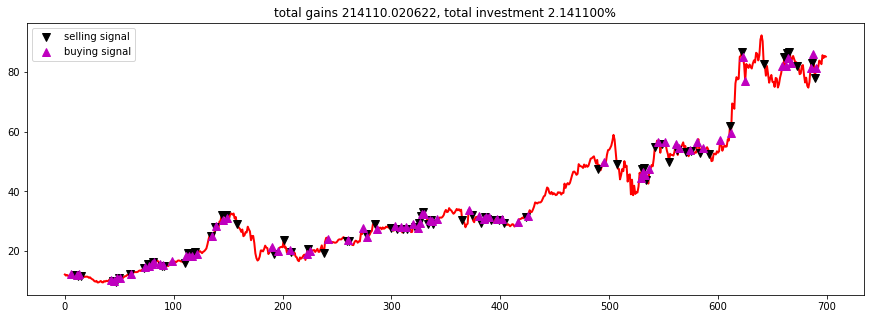

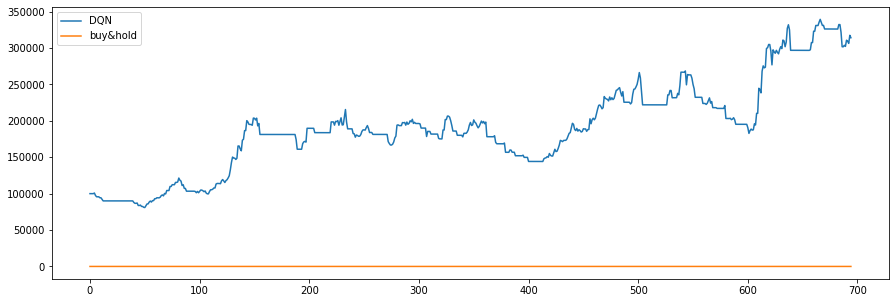

In [ ]:
def game_step(observation, step=None, train=True, show_log=False, my_trick=False):
    
    # RL choose action based on observation
    action = RL.choose_action(observation, train)

    # RL take action and get next observation and reward
    observation_, reward, done = env.step(action, show_log=show_log, my_trick=my_trick)

    RL.store_transition(observation, action, reward, observation_)
    # print("total profit:%.3f" % env.total_profit, end='\r')
    if step and (step > 200) and (step % 5 == 0):
        RL.learn()

    # swap observation
    observation = observation_
    
    return observation, done
    

def run(epcho):
    step = 0
    for episode in range(epcho):
        # initial observation
        observation = env.reset()

        while True:
            
            observation, done = game_step(observation, step=step)
            # print(observation)
            # break while loop when end of this episode
            if done:
                break
            step += 1
        
        print('epoch:%d, total_profit:%.3f' % (episode, env.total_profit))
        # BackTest(False)


def BackTest(env, show_log=True, my_trick=False):
    observation = env.reset()
    # step=0
    while True:
        observation, done = game_step(observation, train=False, 
                                      show_log=show_log, my_trick=my_trick)
        # break while loop when end of this episode
        if done:
            break
    print('total_profit:%.3f' % (env.total_profit))
    return env


if __name__ == "__main__":
    epcho = 10
    
    env = stock(df_copy.iloc[0:731])
    RL = DeepQNetwork(env.n_actions, env.n_features,
                      learning_rate=0.02,
                      reward_decay=0.9,
                      e_greedy=0.9,
                      replace_target_iter=200,
                      memory_size=4000,
                      batch_size=512,
                      # output_graph=True
                      )
    run(epcho)
    # env = stock(df)
    # env = BackTest(env, show_log=True)
    # env.draw('trade.png', 'profit.png')
    
    env = stock(df.iloc[0:731].reset_index(drop=True))
    env = BackTest(env, show_log=True)
    env.draw('trade1.png', 'profit1.png')  
    env = BackTest(env, show_log=True, my_trick=True)
    env.draw('trade2.png', 'profit2.png')
    # RL.plot_cost()

In [ ]:
df_copy

,Date,Open,High,Low,Close,Adj Close,Volume,ma5,ma10,ma21,ma30,ma5_trend,rate1,rate2,ma10_trend,ma21_trend,ma30_trend
0,2018-02-15,12.400000,12.630000,12.070000,12.190000,12.190000,59593800,11.832000,11.765,12.359524,12.262000,1,0.003333,0.001743,2,0,0
1,2018-02-16,12.110000,12.230000,11.820000,11.820000,11.820000,47332300,11.934000,11.702,12.328571,12.252000,1,0.001743,-0.000816,2,0,0
2,2018-02-20,11.720000,12.190000,11.710000,12.020000,12.020000,47096500,12.002000,11.747,12.301429,12.256667,1,-0.000816,0.000381,0,0,0
3,2018-02-21,12.120000,12.120000,11.720000,11.720000,11.720000,40195800,11.990000,11.754,12.257143,12.238000,0,0.000381,-0.001523,0,0,0
4,2018-02-22,11.820000,12.000000,11.630000,11.840000,11.840000,37886300,11.918000,11.778,12.204762,12.238667,0,-0.001523,0.000054,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,2020-11-18,83.010002,83.959999,82.220001,82.540001,82.540001,29968000,82.580000,82.417,80.390476,81.381666,0,-0.000458,-0.001697,0,0,0
696,2020-11-19,82.389999,85.639999,81.720001,85.540001,85.540001,50116800,83.320001,82.671,80.692381,81.349333,0,-0.001697,-0.000397,0,0,0
697,2020-11-20,85.279999,86.099998,84.470001,84.639999,84.639999,34974800,83.962001,82.547,80.940952,81.400666,1,-0.000397,0.000631,0,0,0
698,2020-11-23,85.519997,87.540001,84.620003,85.309998,85.309998,46505000,84.278000,82.766,81.100476,81.434666,0,0.000631,0.000418,0,0,0
